### Normalizing flow using nflows package and toy data 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import rel_breitwigner
import torch
#instead of manually defining bijectors and distributions, 
#import necessary components from nflows
from nflows import distributions, flows, transforms
import nflows.transforms as transforms
from nflows.flows import Flow


## Setup: 
- #### bkg: exponential falling distribution
- #### signal: Breit-Wigner at certain mass 

In [2]:

# Generate background and signal data
n_bkg = 400000
n_sig = 20
bkg = np.random.exponential(scale=100.0, size=n_bkg)
sig = rel_breitwigner.rvs(450, size=n_sig)


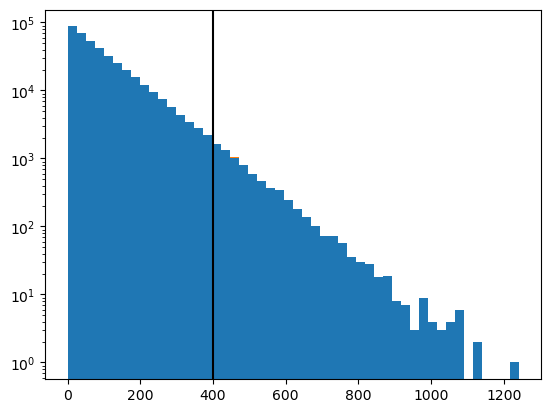

In [3]:
# Plot histogram
plt.hist([bkg, sig], bins=50, stacked=True)
plt.yscale('log')
plt.axvline(400.0, color='black', zorder=100)  # mass threshold or cut
plt.show()


In [4]:

# Adding b-tagging information (a form of event classification)
bkg_btag = np.random.uniform(low=0.0, high=1.0, size=n_bkg)
sig_btag = np.random.normal(0.85, 0.05, n_sig)

print(bkg_btag)

[0.32341661 0.40921988 0.8897746  ... 0.35350044 0.03109549 0.21362902]


In [5]:

#Combining energy and b-tagging score for both bkg and signal 
#Convert background coordinates to tensor
bkg_coord = np.column_stack((bkg_btag, bkg))  # Combine btag and bkg for training
bkg_coord = bkg_coord.astype('float32') #bkg coordinates converted to float32 for compatibility with python 

#sig_coord = np.column_stack((sig, sig_btag))
#sig_coord = sig_coord.astype('float32')

print(bkg_coord.shape)


(400000, 2)


In [6]:

#sample points from target distribution 
y = torch.from_numpy(bkg_coord[:100000])  # Take the first 100,000 samples

print(y.shape)

torch.Size([100000, 2])


Note: the bkg distribution is the posterior/target distribution which the Normalizing Flow should learn to approximate. 


## Normalizing flow model:
#### Set up simple normalizing flow with arbitrary inputs and outputs just to test 

In [7]:
# Define base distribution
# base distribution = prior distribution that the Normalizing Flow will transform 
base_distribution = distributions.StandardNormal(shape=(2,))

# Define transformations (bijectors)
# you don't need to define a customed bijector anymore 
transformations = transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=16, num_blocks=3)

Note: 
- features=2: dimensionality of the data being transformed, which in this case is 2 since you are combining the b-tagging score and background energy.
- hidden_features=16: size of the hidden layers in the neural network that defines the transformation. The higher the number of hidden features, the more expressive the transformation will be, allowing it to capture more complex relationships in the data. In this case, each transformation in the flow is backed by a neural network with 16 hidden units.

The neural network basically has the base distribution values as inputs and gets to the parameters of the target distribution (via the network). Then those parameters are inserted in the target distribution to get the ouputs in correspondence to the inputs. In this case, the neural network has 16 layers. 

Using a neural network inside the transformations in normalizing flows does make the training loop "deeper" in the sense that you're not just applying a single transformation but a series of transformations that are learned through the neural network.

### Setting up the normalizing flow and the training loop

In [8]:

#Create the flow
flow = Flow(transformations, base_distribution) #encapsules the entire flow model in a more structured way

#Training loop
#The training loop remains similar,
#but with flow.log_prob(y) directly calculating the log probability using the nflows implementation.
opt = torch.optim.Adam(flow.parameters(), lr=5e-4)

#print(base_distribution)
#print(flow)

last_loss = np.inf
patience = 0
n_epochs = 4001

for idx in range(n_epochs):
    opt.zero_grad()

    # Minimize KL(p || q)
    loss = -flow.log_prob(y).mean()

    if idx % 1 == 0:
        print('epoch', idx, 'loss', loss)

    loss.backward()

    # Early stopping based on patience
    #patience mechanism keeps track of how many epochs have passed without improvement in loss. 
    #If the loss does not improve for 5 consecutive epochs, the training stops early to prevent overfitting.

    if loss > last_loss:
        patience += 1
    if patience >= 5:
        break
    last_loss = loss

    opt.step()


epoch 0 loss tensor(4841.8975, grad_fn=<NegBackward0>)
epoch 1 loss tensor(4755.9517, grad_fn=<NegBackward0>)
epoch 2 loss tensor(4671.2612, grad_fn=<NegBackward0>)
epoch 3 loss tensor(4587.5845, grad_fn=<NegBackward0>)
epoch 4 loss tensor(4504.8862, grad_fn=<NegBackward0>)
epoch 5 loss tensor(4423.1592, grad_fn=<NegBackward0>)
epoch 6 loss tensor(4342.4033, grad_fn=<NegBackward0>)
epoch 7 loss tensor(4262.6182, grad_fn=<NegBackward0>)
epoch 8 loss tensor(4183.8076, grad_fn=<NegBackward0>)
epoch 9 loss tensor(4105.9707, grad_fn=<NegBackward0>)
epoch 10 loss tensor(4029.1084, grad_fn=<NegBackward0>)
epoch 11 loss tensor(3953.2202, grad_fn=<NegBackward0>)
epoch 12 loss tensor(3878.3018, grad_fn=<NegBackward0>)
epoch 13 loss tensor(3804.3469, grad_fn=<NegBackward0>)
epoch 14 loss tensor(3731.3499, grad_fn=<NegBackward0>)
epoch 15 loss tensor(3659.3159, grad_fn=<NegBackward0>)
epoch 16 loss tensor(3588.2400, grad_fn=<NegBackward0>)
epoch 17 loss tensor(3518.1155, grad_fn=<NegBackward0>)
ep

In [9]:
#Sampling: done using the provided methods from nflows
# Sample points from the base distribution
prior = base_distribution.sample(1000).numpy()  # Sample 1000 points with 2 features each

# Sample points from the trained flow
trained = flow.sample(1000).detach().numpy()  # Sample 1000 points with 2 features each


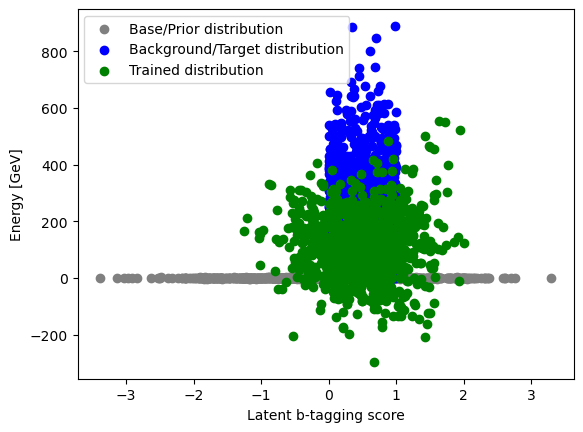

In [10]:
plt.scatter(prior[:, 0], prior[:, 1], color='gray', label='Base/Prior distribution')
plt.scatter(bkg_coord[:10000, 0], bkg_coord[:10000, 1], color='blue', label='Background/Target distribution')
plt.scatter(trained[:, 0], trained[:, 1], color='green', label='Trained distribution')
plt.xlabel("Latent b-tagging score")
plt.ylabel("Energy [GeV]")
plt.legend()
plt.show()
